In [359]:
import pandas as pd
import numpy as np

from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import PandasTools
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import AllChem
from rdkit.Chem import rdFingerprintGenerator
from rdkit import DataStructs
from rdkit.Chem import MACCSkeys
from rdkit.Chem.Fingerprints import FingerprintMols
import matplotlib.pyplot as plt

from descriptastorus.descriptors.DescriptorGenerator import MakeGenerator
#https://github.com/bp-kelley/descriptastorus


In [99]:
full_copy = pd.read_csv('../../../project1_data/Series4_workingCopy.csv', index_col = 'ID')
# full_copy.head()

In [83]:
PandasTools.AddMoleculeColumnToFrame(full_copy,smilesCol='SMILES')
# full_copy.head()

# Generating descriptors using RDKit

In [84]:
# RDKit
generator = MakeGenerator(("RDKit2D",))

full_copy_rdkit2d = [generator.process(x)[1:] for x in full_copy['SMILES']]

In [85]:
rdkit2d_name = []
for name, numpy_type in generator.GetColumns():
    rdkit2d_name.append(name)
    
full_copy_rdkit2d_df = pd.DataFrame(full_copy_rdkit2d, index = full_copy.index, columns=rdkit2d_name[1:])

In [86]:
# full_copy_rdkit2d_df.head()

In [87]:
full_copy_rdkit2d_df.to_csv('../../../project1_data/full_copy_rdkit2d_df.csv')

In [88]:
allMerged = pd.merge(full_copy,full_copy_rdkit2d_df,left_on='ID',right_on='ID')

In [358]:
allMerged.to_csv('../../../project1_data/full_copy_with_Descriptors.csv')
# allMerged

In [357]:
allMerged = pd.read_csv('../../../project1_data/full_copy_with_Descriptors.csv', index_col = 'ID')
allMerged.dropna(inplace=True)
allMerged.drop(allMerged[allMerged.clearance > 49.9].index, inplace=True)
allMerged.drop(allMerged[allMerged.desired < 4.6].index, inplace=True)
allMerged.drop(allMerged[allMerged.clearance < 0.51].index, inplace=True)
# allMerged[allMerged['clearance'] > 49.9 ]
# allMerged

FileNotFoundError: [Errno 2] No such file or directory: '../../../project1_data/full_copy_with_Descriptors.csv'

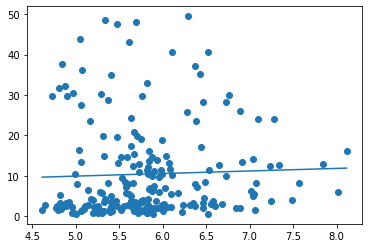

In [328]:
X_plotting=allMerged.iloc[:, 1].values #desirable data
y_plotting=allMerged.iloc[:, 2].values #clearance
plt.scatter(X_plotting, y_plotting)
m, b = np.polyfit(X_plotting, y_plotting, 1)
plt.plot(X_plotting, m*X_plotting + b)

In [329]:
allMerged_processed = allMerged.drop(['clearance'], axis=1)
# allMerged_processed = allMerged.drop(['desired'], axis=1)

In [330]:
allMerged_processed = allMerged_processed.drop(['ROMol'], axis=1)

In [331]:
allMerged_processed.shape

(208, 202)

#Random forest 

In [350]:
X = allMerged_processed.iloc[:, 2:,].values #descreptors
y = allMerged_processed.iloc[:, 1].values #desired property
# y

In [351]:
print(X.shape)
# print(y)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
# print(X_train.shape)
# print(X_test.shape)
# print(y_train.shape)
# print(y_test.shape)

(208, 200)


In [352]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [353]:
from sklearn.ensemble import RandomForestRegressor

regressor = RandomForestRegressor(n_estimators=2000, random_state=0)
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)

In [354]:
from sklearn import metrics

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print(y_test)
print(y_pred)

Mean Absolute Error: 0.460488117899668
Mean Squared Error: 0.37119518769907284
Root Mean Squared Error: 0.609257899168384
[4.891 5.592 5.139 4.799 6.768 5.609 5.819 5.838 5.651 6.096 5.288 6.105
 5.338 6.887 5.684 5.632 7.566 5.197 5.434 4.963 6.43  4.906 4.821 5.373
 5.655 5.896 5.844 5.842 6.178 6.682 5.529 6.028 5.929 5.48  6.728 5.992
 6.488 5.821 4.927 5.898 6.895 5.01 ]
[5.93613897 5.51965467 5.53342961 5.88811249 6.12059079 5.52374675
 5.99609658 5.76932759 5.74567254 5.89535708 5.56261492 5.55342927
 5.54783782 6.29328859 5.2526393  5.53543671 5.67927096 5.37152402
 5.95641416 5.32197884 6.12059079 5.74018642 5.91827921 5.75801837
 5.58622765 6.6005258  6.2923153  5.66226441 5.65537627 6.5914096
 5.65041231 5.95894452 6.14463167 6.12059079 6.34940178 5.68169575
 6.82540056 5.57039739 5.69691478 5.70050705 5.55640839 6.10537112]


In [349]:
###Predicting for the new set of desirable data
validation = pd.read_csv('../../../project1_data/validation.csv', index_col = 'ID')
validation.dropna(inplace=True)
# validation

FileNotFoundError: [Errno 2] No such file or directory: '../../../project1_data/validation.csv'

In [311]:
X_valid = validation.iloc[:, 2:,].values #descreptors
y_valid = validation.iloc[:, 1].values #desirable data
X_valid.shape


(67, 200)

In [316]:
Y_valid_pred = regressor.predict(X_valid)
print(Y_valid_pred)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_valid, Y_valid_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_valid, Y_valid_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_valid, Y_valid_pred)))

[5.87170103 5.85636491 5.84370311 5.82860938 5.85642589 5.88699609
 5.87945608 5.88106323 5.85642589 5.848766   5.88287313 5.85642589
 5.88809684 5.85010045 5.88215191 5.886967   5.85058983 5.85010045
 5.88650328 5.87538522 5.85010045 5.85058983 5.87892583 5.88454222
 5.88346151 5.85991745 5.88106323 5.88237318 5.85636491 5.85051062
 5.87733807 5.84945383 5.88650328 5.82994409 5.87553453 5.89785492
 5.84370311 5.88552369 5.88287313 5.89296691 5.8742803  5.88818259
 5.88287313 5.83287927 5.87883918 5.8894941  5.88650328 5.85636491
 5.82829786 5.83577336 5.82664574 5.86901304 5.85684154 5.88078023
 5.84094424 5.87319212 5.87200694 5.83433463 5.85123273 5.86518354
 5.86371466 5.87605529 5.86619572 5.88681042 5.89323957 5.84370311
 5.86428295]
Mean Absolute Error: 0.5951765572672263
Mean Squared Error: 0.532982467565765
Root Mean Squared Error: 0.7300564824489711


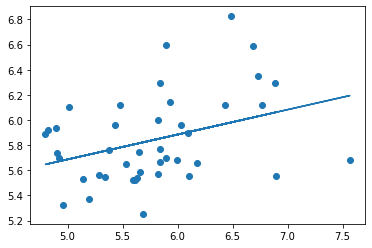

In [355]:
from sklearn.metrics import r2_score
plt.scatter(y_test, y_pred)
m, b = np.polyfit(y_test, y_pred, 1)
plt.plot(y_test, m*y_test + b)
# plt.axes.set_title()
# plt.title('R2: ' + str(r2_score(y_test, y_pred)))
# for f in y_pred:
#     print (f)

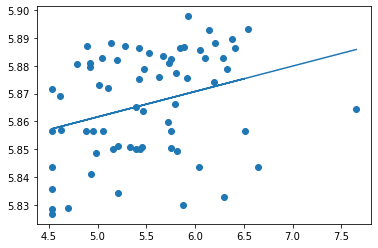

In [356]:
plt.scatter(y_valid, Y_valid_pred)
m, b = np.polyfit(y_valid, Y_valid_pred, 1)
plt.plot(y_valid, m*y_valid + b)
# plt.title('R2: ' + str(r2_score(y_valid, Y_valid_pred)))

In [284]:
from sklearn import metrics

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 0.4885241984496014
Mean Squared Error: 0.367773779643749
Root Mean Squared Error: 0.6064435502532358
